### Spatial Optimization

Spatial optimization is a multi-diciplanary field decdicated to the scientific and rational allocation of resources across a surface. It area has recieved considerable interest within the fields of economics, geography, computer science, operations research and management science. Spatial optimization provides the theoretical underpinnings and solutions for the development of spatial arangments that support a given cost function. However, the complexity of spatial optimization problems -  especially those with a high degree of dimensionality - poses critical clallenges in spatial optimization modeling and efficency, especially in a market focused on (near) real time solutions. 

A wide range of approaches exist for evaluating spatial optimization problems. First an evaluation of the problem will yield the dimentionality needed - are we optimizing over a single variable or ar there multiple variables to consider? The optimal location of a distribution center may take into account several factors, including routing, proximity to manufacture/custormer, taxes, etc. The optimal location of infrustructure such as weather radar needs to be disperse for coverage for a finite sized set of sensing hardware, but these locations likely need to be located with some proximity to population centers to ensure addequate coverage for a large population of people. Further still some solutions may need to take into account existing locations that are fixed geographically, optimizing around existing infrustructure. 

Once a problem has been developed with an objective and the constraints, a solver is generally used (e.g., [IBM CPLEX Optimization Studio](https://www.ibm.com/products/ilog-cplex-optimization-studio); [LINGO 21](https://lindo.com/index.php/products/lingo-and-optimization-modeling)). Exact solutions can be obtained for some problems, however with an increase indimentianality comes a combinatorial explosion - where solutions may exist as n-dimentional surfaces. In these cases a more heuristic search technique may be prefered. Heuristic algorithms are able to retuen a solution (not necesarly optimal) for a problem in a given timeframe. Some heuristic solutions return a suboptimal solution rapidly (e.g. myopic, naïve strategy), whereas other can lead to an optimal (simulated annealing, genetic algorithms, tabu search), at the cost of a longer running time.

The following from [Delmell E. (2010)](https://pages.charlotte.edu/wp-content/uploads/sites/150/2012/12/Spatial_Optimization_Methods-2.pdf) covers the varying types of solving approaches to spatial optimization problems: 

* **Naive or random strategy**
  The naïve strategy randomly chooses a number of locations from a set of candidate locations. This approach does not account for the structure of the solution space and is therefore very inefficient. Nevertheless, the numerical results following the use of this algorithm provide a good lower bound to evaluate other heuristics.

* **Total enumeration**
  This method consists of evaluating which of all candidate locations optimizes the objective function the best. Total enumeration is sensitive to the size of the problem, but is optimal in the one-facility location problem as long the set of candidate solutions is finite (discrete). The method would however be inappropriate when the spatial problem calls for the allocation of more than one facility, because of combinatorial explosion.

* **Greedy algorithm**
  Greedy (or myopic) starts with a feasible solution. The current solution is then exchanged
for another one only if the objective function improves. The process continues until no further improvements can be made. The algorithm is easy to implement and returns a good solution, which may be sub-optimal however. The algorithm can be effective when applied repeatedly as long the starting feasible solution is changed. Simulated annealing
The greedy approach, as well as the total enumeration in the one-facility location usually
get stuck in a local optimum while simulated annealing is able to reach optimality. The major advantage of Simulated Annealing is its ability to avoid becoming trapped at a local maximum. The algorithm employs a stochastic search that accepts changes improving the objective function, but also non-improving moves, which are accepted with a certain probability. The probability of acceptance decreases as the temperature (or system) cools down.

* **Tabu Search**
  Simulated annealing allows non-improving moves. Tabu search however deals with cycling problems of non-improving moves, in which the heuristic momentarily forbids swapping of solution that would return to a previously visited solution. The so called ―tabu-list‖ records these forbidden moves.

* **Metaheuristics**
  The combination of two heuristic methods—also called a metaheuristic—allows one to improve upon a first solution. For instance, because the greedy heuristic may yield a suboptimal solution, an improvement may be desirable; simulated annealing can use the greedy solution at the start of its optimization procedure.

* **Genetic algorithm**
  A genetic algorithm is a metaheuristic that uses techniques from evolutionary biology to find better solutions at each iteration. The algorithm improves feasible or suboptimal solutions by operations which combine individuals of an improving population. The quality of each\ individual is evaluated, and several of them are randomly selected from the current solution, based on their solution quality. Solutions are then modified using mutation or crossover to form a new basic feasible solution.

### Applied example - Spatial Line of Sight Optimization

We will tackle the problem of placing several "towers" within line of sight within a domain. First we will build a more simple example, functioning in 2 dimentions with a greedy approach before employing optimization libraries for a 3 dimentional case. 

We need to start by building some terrain. For this we will generate the features of a canyon (basin and range) across a given square map size using some trigonometric functions, some smoothing, and a sprinkle of random noise. The end goal is to create a canyon landscape covered by "trees" (represented by noise) that our "tower" can poke above. Finally we will generate a surface of valid locations to place the towers.

In [5]:
# Some basic imports
import numpy as np                           # Array manipulation
import matplotlib.pyplot as plt              # Visulization
from scipy.ndimage import gaussian_filter    # Smoothing


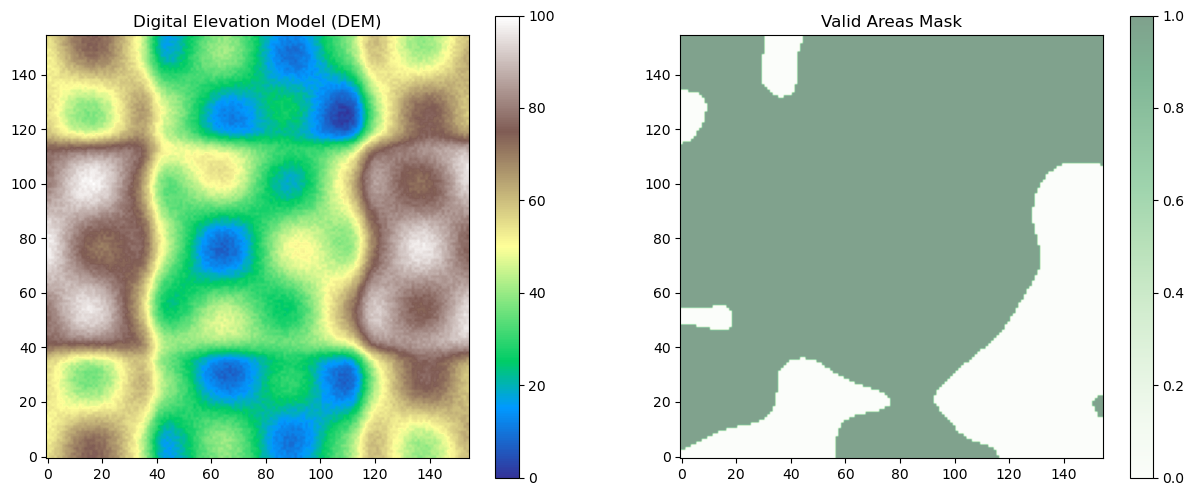

In [6]:
# Define map size (keeping it small (~100) helps with efficency at the cost of resolution)
map_size = 155

# Generate structured DEM data coordinates 
x, y = np.meshgrid(np.linspace(-10, 10, map_size), np.linspace(-10, 10, map_size))

# Create "basin and range" structure using combined functions and Gaussian filters
dem = (np.sin(x) * np.cos(y) * 20 + 
       np.sin(0.5 * x) * np.cos(0.5 * y) * 10 + 
       np.sin(0.25 * x) * np.cos(0.25 * y) * 5)

# Apply Gaussian filter to smooth out the DEM
dem = gaussian_filter(dem, sigma=2)

# Add aggressive cliffs and valleys
cliffs = (np.tanh(2 * (x - 5)) - np.tanh(2 * (x + 5))) * 20
valleys = - (np.tanh(2 * (y - 5)) - np.tanh(2 * (y + 5))) * 20
dem += cliffs + valleys

# Apply another Gaussian filter to help smooth smooth transitions a little
dem = gaussian_filter(dem, sigma=1)

# Add random noise
dem += np.random.rand(map_size, map_size) * 5

# Add lakes (negative values will be below sea level)
dem -= (np.exp(-0.05 * ((x - 2)**2 + (y - 2)**2)) * 30 + 
        np.exp(-0.05 * ((x + 2)**2 + (y + 2)**2)) * 30)

# Normalize DEM to be within 0 to 100 feet range
dem = 100 * (dem - np.min(dem)) / (np.max(dem) - np.min(dem))

# Generate structured valid areas mask using a Gaussian function
valid_mask_base = np.exp(-0.1 * (x**2 + y**2))  # Gaussian distribution

# Add blocks of random noise and apply Gaussian filter to create blobs
np.random.seed(42)  # For reproducibility
noise = np.random.rand(map_size, map_size)
smooth_noise = gaussian_filter(noise, sigma=10)  # Adjust sigma for larger/smaller blobs
valid_mask = (valid_mask_base + smooth_noise) > 0.5  # Combine and threshold

# Visualize the DEM and valid mask with terrain colormap and colorbars
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

c1 = axs[0].imshow(dem, cmap='terrain', origin='lower')  #imshow places orgin in upper left (image orgin), we want lower left (cartesian crds)
axs[0].set_title('Digital Elevation Model (DEM)')
fig.colorbar(c1, ax=axs[0], orientation='vertical')

c2 = axs[1].imshow(valid_mask, cmap='Greens', alpha=0.5, origin='lower')
axs[1].set_title('Valid Areas Mask')
fig.colorbar(c2, ax=axs[1], orientation='vertical')

plt.show()


In the above figure we can see several features:
* a dominate "canyon" through the middle of the domain
* smaller "mounds" - surface variation of about a 3x the frequency of the canyon
* finer variation still from random surface noise

The valid areas mask indicates where it will be okay to place towers (green), and where it is not okay (white).

We need some mechanism for a tower to "see" the map. We will start with a simple 2-D case. If a point is located sommewhere in the domain (say (x=50, y=60, elevation=70)), the terrain may block our vision of other areas of the map. If we think of this in a 2-D case we can place ourselves at the point with a laser range-finder. this range finder only operates perfectly level with the ground, so as we spin around 360 degrees we can measure the distance to the terrain or out to the max range of the finder (say 50 meters). 

There are several approaches to scanning with our range finder, but we will focus on generating an approximation of the view range through casting rays out from our tower, as if we take our range finder and check the distance every 4 degrees, then record that information, so we hav a 2-dimensional point cloud measuring the tower sorroundings on a plane that is normal to the force of gravity (perfectly horizontal).  

In [7]:
# define what a tower looks like
obs_height=10  # Height of tower
max_radius=40  # How far the tower can influence, brodcast, or "see"
num_rays=90    # How the tower samples the space: 360 degrees / num_rays

In [4]:
# We define a cast ray function which is akin to measuring the distance for a single angle
#    with a laser range finder held perfectly horizontal. This finction will be called by
#    a parent function that will step through all the angle possiblilities to measure. 
# This function takes the DEM we generated, the x/y point we are interested in measuring
#    from, the angle we want to measure at, the height above the DEM at that X/Y point we
#    are measuring from, and the max value the range finder can measure (anything beyond
#    will return the max value)

"""
Cast a ray from the observation point in a given direction and check for visibility.
"""
def cast_ray(dem, obs_x, obs_y, angle, obs_height=60, max_radius=50):
    dem_size = dem.shape[0]
    visible_points = []
    dx = np.cos(angle)
    dy = np.sin(angle)
    obs_elevation = dem[obs_x, obs_y] + obs_height

    # step out in increments of 1 (integer steps for efficency)
    for step in range(1, max_radius + 1):
        x = obs_x + step * dx
        y = obs_y + step * dy
        
        # If we reach the edge of the DEM break out of loop, we don't know what is beyond.
        if x < 0 or y < 0 or x >= dem_size or y >= dem_size:
            break
        x_int = int(round(x))
        y_int = int(round(y))
        if x_int < 0 or y_int < 0 or x_int >= dem_size or y_int >= dem_size:
            break

        
        # Find distance with distance formula
        distance = np.sqrt((x - obs_x)**2 + (y - obs_y)**2)
        target_elevation = dem[x_int, y_int]

        
        # See if surface elevation and ray elevation at that distance have intersected 
        line_elevation = obs_elevation - (obs_elevation - target_elevation) * (distance / max_radius)
        
        if target_elevation > line_elevation:
            break
            
        # if point along ray is visible (e.g. hasn't run into surface yet), append
        visible_points.append((x_int, y_int))
    
    return visible_points

"""
Driver parent function to step through all of the angle possibilities and accumulate
    the results of all the measurments
"""
def get_visible_area(dem, obs_x, obs_y, obs_height=60, max_radius=50, num_rays=90):
    dem_size = dem.shape[0]            # side size of the square DEM
    visible_area = np.zeros_like(dem)  # empty array to accumulate if a point is seen by any ray

    # loop through all of the ray angles in radians, get points that are visible by that ray,
    #    and add to the accumulation in visible aras
    for angle in np.linspace(0, 2 * np.pi, num_rays, endpoint=False):
        visible_points = cast_ray(dem, obs_x, obs_y, angle, obs_height, max_radius)
        for x, y in visible_points:
            visible_area[x, y] = 1
    
    return visible_area


Next we need points to evaluate, we will start with search of the domain space, evaluating the visibility from all locations that are not covered (many checks). If a point falls in an invalid location we will assign it a score of 0 and move on. This is a relativly naive approach, we need to use multiple CPU cores to speed the process up.

This approach works by finding the best point based off of its visibility in the parameter space. It then repeats this process with the next point(s), but aware of the coverage by the previous point(s), untill it has placed n_points. 

This approach is naive as the optimal solution may not inculude the optimal single point in the paramter space (unless you are trying to optimize for a single point, in that case we found the best solution), it is possible for two less optimal points to have better coverage than a one optimal point with a second highly sub-optimal point. 

As this is an exhaustive search that does not rely on seed points it is repetable and wou will get the same results for the same set of inputs no matter how many times the script is executed. However with more points or a larger DEM the time complexity increases at $O(n\_points×dem\_size^2)$

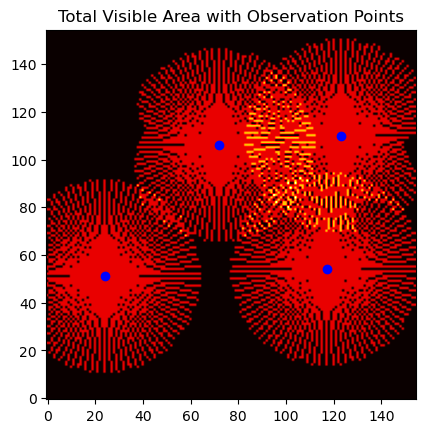

Observation Points: [(54, 117), (106, 72), (51, 24), (110, 123)]


In [5]:
# Imports for multiprocessing
from multiprocessing import Pool, cpu_count  

# Get the visibility score (count of points visible from get_visible_area()),
#    0 if point is invalid.
#    called by multiprocessing
def process_point(args):    #defined to take an args argument vs individual arguments for multiprocesssing
    dem, valid_mask, total_visible_area, obs_height, max_radius, num_rays, i, j = args
    if valid_mask[i, j] == 1 and total_visible_area[i, j] == 0:
        visible_area = get_visible_area(dem, i, j, obs_height, max_radius, num_rays)
        visibility_score = np.sum(visible_area * (1 - total_visible_area))
        return visibility_score, (i, j), visible_area
    return 0, None, None

def place_observation_points(dem, valid_mask, n_points, obs_height=10, max_radius=40, num_rays=90):
    dem_size = dem.shape[0]   # size of side of the square DEM
    total_visible_area = np.zeros_like(dem)  # empty array to accumulate how many times a point is seen by a ray
    observation_points = []  # list for the observation points we find if they are a "best point"

    # loop n_points times, finding best one, then the next best, next best, and so-on. 
    for _ in range(n_points):
        best_visibility = 0       # best visibility we encounter as we loop through
        best_point = None         # best point
        best_visible_area = None  # best area seen

        # use all but 1 cpu core to process points as fast as possible
        with Pool(cpu_count()-1) as pool:
            results = pool.map(process_point, [(dem, valid_mask, total_visible_area, obs_height, max_radius, num_rays, i, j)
                                               for i in range(dem_size) for j in range(dem_size)])

        # check through all the results for the next point placement, log the best. 
        for visibility_score, point, visible_area in results:
            if visibility_score > best_visibility:
                best_visibility = visibility_score
                best_point = point
                best_visible_area = visible_area
        
        if best_point:
            observation_points.append(best_point)
            total_visible_area += best_visible_area
    
    return observation_points, total_visible_area

"""
Driver code for the place_observation_points function, 
#    followed by a quick plot of the results for a sanity check
"""
# Place observation points
n_points = 4  # adding more points increases the time complexity: O(n_points×dem_size^2)
observation_points, total_visible_area = place_observation_points(dem, valid_mask, n_points,
                                                                  obs_height=obs_height,
                                                                  max_radius=max_radius,
                                                                  num_rays=num_rays)

# Visualize the total visible area
plt.imshow(total_visible_area, cmap='hot', origin="lower")
plt.title('Total Visible Area with Observation Points')
plt.scatter([p[1] for p in observation_points], [p[0] for p in observation_points], c='blue')
plt.show()

print("Observation Points:", observation_points)


Now let's view these points and the areas they can see on the original DEM and placement relative to the invalid areas. 


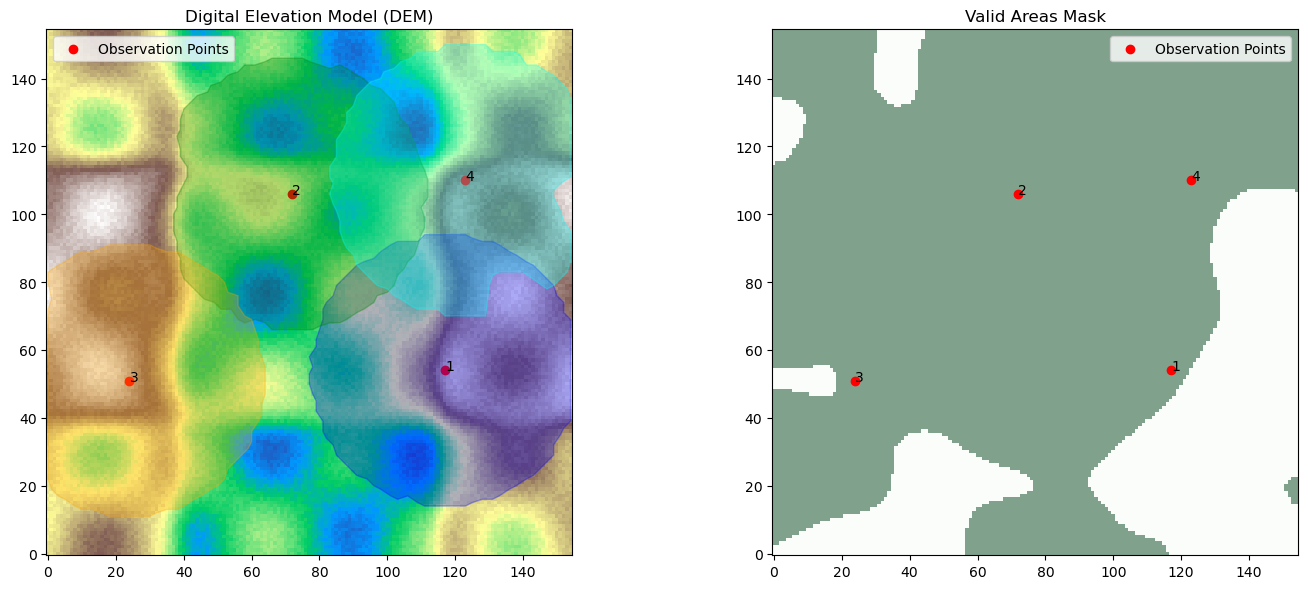

In [6]:
# import so we can turn a bunch of points (visibility from rays) into a polygon
from shapely.geometry import Polygon as ShapelyPolygon


def plot_observation_points_with_polygons_on_dem(dem, valid_mask, observation_points, obs_height=10, max_radius=40, num_rays=90):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot DEM
    axes[0].imshow(dem, cmap='terrain', origin='lower')
    axes[0].set_title('Digital Elevation Model (DEM)')
    axes[0].scatter([p[1] for p in observation_points], [p[0] for p in observation_points], c='red', label='Observation Points')

    # Annotate points with their order
    for i, (x_coord, y_coord) in enumerate(zip([p[1] for p in observation_points], [p[0] for p in observation_points])):
        axes[0].annotate(str(i + 1), (x_coord, y_coord)) # str(i + 1) to transition from getting the index of the point in 0 index to make it into 1 indexed for visulization
    
    axes[0].legend()
    
    # Plot polygons for visible areas on DEM
    # This uses the same base code get_visible_area() and cast_ray() uses, however these functions do not return the data in the format we need 
    colors = ['blue', 'green', 'orange', 'cyan', 'magenta', 'plum', 'goldenrod']  # Unique colors for each observation point
    for idx, (obs_x, obs_y) in enumerate(observation_points):

        polygon_points = []
        for angle in np.linspace(0, 2 * np.pi, num_rays, endpoint=False):
            ray_x = [obs_x]
            ray_y = [obs_y]
            dx = np.cos(angle)
            dy = np.sin(angle)
            obs_elevation = dem[obs_x, obs_y] + obs_height

            for step in range(1, max_radius + 1):
                x = obs_x + step * dx
                y = obs_y + step * dy
                x_int = int(round(x))
                y_int = int(round(y))
                if x_int < 0 or y_int < 0 or x_int >= dem.shape[0] or y_int >= dem.shape[1]:
                    break

                distance = np.sqrt((x - obs_x)**2 + (y - obs_y)**2)
                target_elevation = dem[x_int, y_int]
                line_elevation = obs_elevation - (obs_elevation - target_elevation) * (distance / max_radius)

                if target_elevation > line_elevation:
                    break

                ray_x.append(x_int)
                ray_y.append(y_int)

            if len(ray_x) > 1:
                polygon_points.append((ray_x[-1], ray_y[-1]))  # Append the endpoint of the ray

        # Create a Shapely Polygon from the collected points
        polygon = ShapelyPolygon(polygon_points)
        
        # Plot the Polygon on DEM
        x, y = polygon.exterior.xy   # grab all the points that denote the exterior of the polygon
        axes[0].fill(y, x, color=colors[idx], alpha=0.3)

    # Plot Valid Mask
    axes[1].imshow(valid_mask, cmap='Greens', alpha=0.5, origin='lower')
    axes[1].set_title('Valid Areas Mask')
    axes[1].scatter([p[1] for p in observation_points], [p[0] for p in observation_points], c='red', label='Observation Points')
    
    # Annotate points with their order
    for i, (x_coord, y_coord) in enumerate(zip([p[1] for p in observation_points], [p[0] for p in observation_points])):
        plt.annotate(str(i + 1), (x_coord, y_coord))
    
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_observation_points_with_polygons_on_dem(dem, valid_mask, observation_points, obs_height=10, max_radius=40, num_rays=90)


### Proceed with a 3D variant of the problem with more advanced methods

In [8]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
#from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
#from scipy.spatial import cKDTree
#from scipy.spatial import KDTree
#from scipy.stats.qmc import PoissonDisk
from scipy.optimize import minimize
#from scipy.spatial.distance import pdist, squareform
#from sklearn.cluster import KMeans
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.ops import unary_union#, cascaded_union
#from shapely.validation import explain_validityf

from scipy.optimize import differential_evolution
#from sklearn.cluster import KMeans
#import matplotlib.pyplot as plt
#from scipy.spatial import cKDTree

As before, let's generate a DEM

In [9]:
# Define map size
map_size = 100


# Generate structured DEM data
x, y = np.meshgrid(np.linspace(-10, 10, map_size), np.linspace(-10, 10, map_size))

# Create basin and range structure using combined functions and Gaussian filters
dem = (np.sin(x) * np.cos(y) * 20 + 
       np.sin(0.5 * x) * np.cos(0.5 * y) * 10 + 
       np.sin(0.25 * x) * np.cos(0.25 * y) * 5)

# Apply Gaussian filter to smooth out the DEM
dem = gaussian_filter(dem, sigma=2)

# Add aggressive cliffs and valleys
cliffs = (np.tanh(2 * (x - 5)) - np.tanh(2 * (x + 5))) * 20
valleys = - (np.tanh(2 * (y - 5)) - np.tanh(2 * (y + 5))) * 20
dem += cliffs + valleys

# Apply another Gaussian filter for smooth transitions
dem = gaussian_filter(dem, sigma=1)

# Add random noise
dem += np.random.rand(map_size, map_size) * 5

# Add lakes (negative values will be below sea level)
dem -= (np.exp(-0.05 * ((x - 2)**2 + (y - 2)**2)) * 30 + 
        np.exp(-0.05 * ((x + 2)**2 + (y + 2)**2)) * 30)

# Normalize DEM to be within 0 to 100 feet range
dem = 100 * (dem - np.min(dem)) / (np.max(dem) - np.min(dem))

# Generate structured valid areas mask using a Gaussian function
valid_mask_base = np.exp(-0.1 * (x**2 + y**2))  # Gaussian distribution

# Add blocks of random noise and apply Gaussian filter to create blobs
np.random.seed(42)  # For reproducibility
noise = np.random.rand(map_size, map_size)
smooth_noise = gaussian_filter(noise, sigma=10)  # Adjust sigma for larger/smaller blobs
valid_mask = (valid_mask_base + smooth_noise) > 0.5  # Combine and threshold

# Create grid coordinates for pcolormesh
x, y = np.meshgrid(np.linspace(0, dem.shape[1], dem.shape[1]+1), np.linspace(0, dem.shape[0], dem.shape[0]+1))

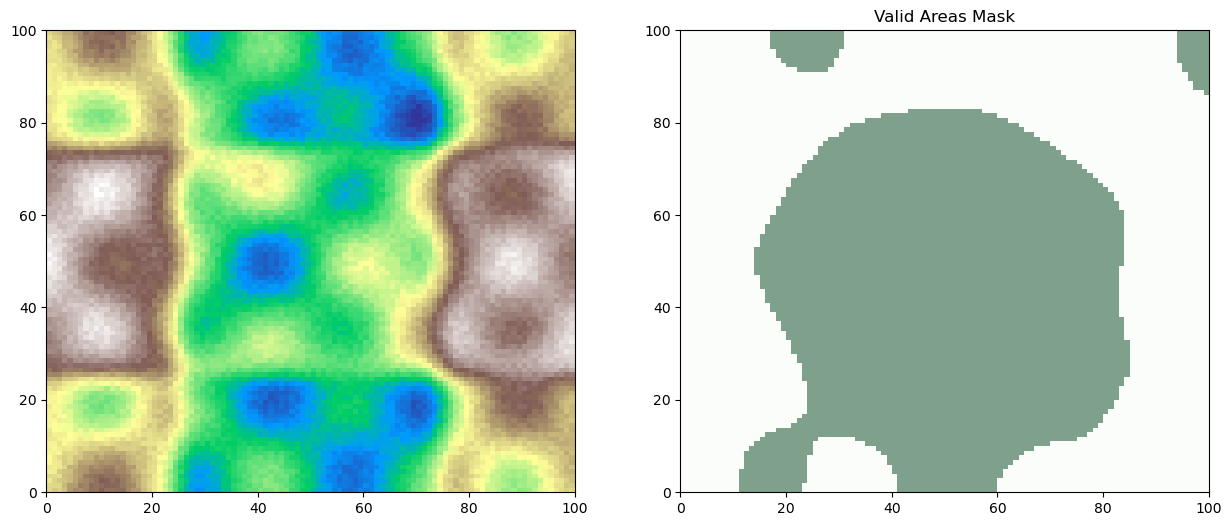

In [10]:
# Visualize the DEM and valid mask with terrain colormap and colorbars
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

c1 = axs[0].pcolormesh(x, y, dem, cmap='terrain', shading='auto')
plt.title('Digital Elevation Model (DEM)')
#plt.colorbar(label='Elevation')

c2 = axs[1].pcolormesh(x, y, valid_mask, cmap='Greens', shading='auto', alpha=0.5)
axs[1].set_title('Valid Areas Mask')

plt.show()


In [11]:
print(valid_mask.shape)

(100, 100)


In the 3-dimentional case we will need some way to quantify visibility in three dimentions, not just blockage within a horizontal plane as with the 2-dimentional case. We can still use the ray idea, a similar function is implemented below, where we terminate the ray (transect) if it is blocked above the horozontal plane. This approach is a bit of a simplification, as we would miss depressions in the DEM if we cannot see over the "lip" due to topography (as in looking over the edge of a cliff, but the lip blocks some of the view)

In [12]:
#import numpy as np
#from shapely.geometry import Polygon as ShapelyPolygon

def get_visible_area_3d_poly(dem, obs_x, obs_y, obs_height, max_radius, num_transects=90):
    polygon_points = []
    dem_shape_0, dem_shape_1 = dem.shape
    
    for angle in np.linspace(0, 2 * np.pi, num_transects, endpoint=False):
        dx = np.cos(angle)
        dy = np.sin(angle)
        obs_elevation = dem[int(np.round(obs_x)), int(np.round(obs_y))]  # Convert to integers

        max_distance = 0
        max_x, max_y = obs_x, obs_y

        for step in range(1, max_radius + 1):
            x = obs_x + step * dx
            y = obs_y + step * dy
            x_int = int(round(x))
            y_int = int(round(y))
            if x_int < 0 or y_int < 0 or x_int >= dem_shape_0 or y_int >= dem_shape_1:
                break

            distance_sq = (x - obs_x)**2 + (y - obs_y)**2
            target_elevation = dem[x_int, y_int]
            line_elevation = (obs_elevation + obs_height) - ((obs_elevation + obs_height) - target_elevation) * (distance_sq / (max_radius ** 2))

            if target_elevation > line_elevation:
                break

            if distance_sq > max_distance:
                max_distance = distance_sq
                max_x, max_y = x_int, y_int

        polygon_points.append((max_x, max_y))  # Append the point to the polygon

    # Create a Shapely Polygon from the collected points
    polygon = ShapelyPolygon(polygon_points)
    return polygon


We can then test the 3d poly and union to ensure we are not double counting area (overlap isn't inherently bad, but our primary goal is coverage)

<Axes: >

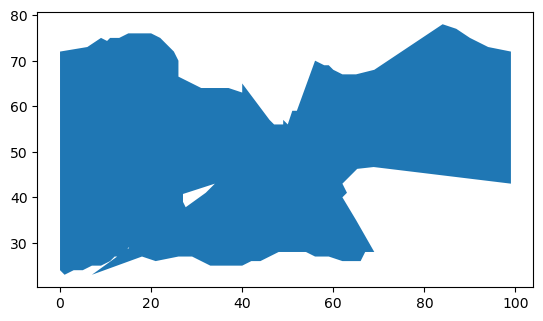

In [13]:
test = get_visible_area_3d_poly(dem, 50, 50, 20, 90, 90)
test2 = get_visible_area_3d_poly(dem, 10, 50, 20, 90, 90)

mergedpoly = gpd.GeoSeries(unary_union([test, test2]))
#test.plot()
mergedpoly.plot()

We can also generate a more accurate view range polygon. Whether or not this is needed depends somewhat on the application (as in: are we trying to see maximum points on the surface (line of sight cellular coverage)? or more generally cover an area (such as with detecting fire smoke)?)

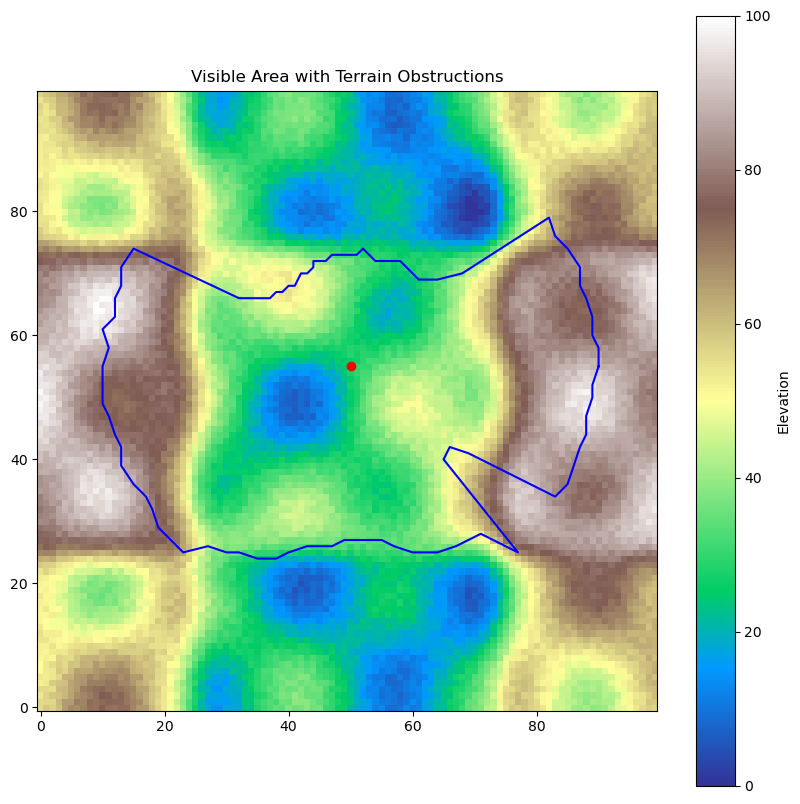

In [14]:
#from shapely.geometry.polygon import LinearRing

#import numpy as np
#import matplotlib.pyplot as plt
#from shapely.geometry import Polygon as ShapelyPolygon, Point as ShapelyPoint, LineString
#from shapely.ops import unary_union
#from descartes import PolygonPatch

from typing import List, Tuple

def get_visible_area_3d_with_obstructions(dem: np.ndarray, obs_x: int, obs_y: int, obs_height: float, max_radius: int, num_transects: int = 90) -> ShapelyPolygon:
    dem_size_x, dem_size_y = dem.shape
    polygon_points: List[Tuple[int, int]] = []
    obstructed_points: List[Tuple[int, int]] = []
    
    angles = np.linspace(0, 2 * np.pi, num_transects, endpoint=False)
    cos_angles = np.cos(angles)
    sin_angles = np.sin(angles)
    obs_elevation = dem[int(np.round(obs_x)), int(np.round(obs_y))]
    
    for dx, dy in zip(cos_angles, sin_angles):
        max_x, max_y = obs_x, obs_y
        transect_points: List[Tuple[int, int]] = []

        for step in range(1, max_radius + 1):
            x = obs_x + step * dx
            y = obs_y + step * dy
            x_int = int(round(x))
            y_int = int(round(y))
            if x_int < 0 or y_int < 0 or x_int >= dem_size_x or y_int >= dem_size_y:
                break
            transect_points.append((x_int, y_int))

        if not transect_points:
            continue

        distances = np.sqrt((np.array([pt[0] for pt in transect_points]) - obs_x)**2 + (np.array([pt[1] for pt in transect_points]) - obs_y)**2)
        back_indices = np.arange(1, max_radius + 1)[:, None]
        back_x = obs_x + back_indices * (np.array([pt[0] for pt in transect_points]) - obs_x) / max_radius
        back_y = obs_y + back_indices * (np.array([pt[1] for pt in transect_points]) - obs_y) / max_radius

        back_x_int = np.clip(np.round(back_x).astype(int), 0, dem_size_x - 1)
        back_y_int = np.clip(np.round(back_y).astype(int), 0, dem_size_y - 1)

        back_elevations = dem[back_x_int, back_y_int]

        for i, point in enumerate(transect_points):
            px, py = point
            obstructed = False

            for j in range(1, len(transect_points) + 1):
                back_elevation = back_elevations[j - 1, i]
                back_distance = distances[i]
                line_elevation_back = (obs_elevation + obs_height) - ((obs_elevation + obs_height) - back_elevation) * (back_distance / max_radius)

                if back_elevation > line_elevation_back:
                    obstructed = True
                    break

            if obstructed:
                obstructed_points.append(point)
            else:
                max_x, max_y = px, py

        polygon_points.append((max_x, max_y))

    # Create the main visible area polygon
    visible_polygon = ShapelyPolygon(polygon_points)

    return visible_polygon

# Observation point
obs_x, obs_y = 50, 55
obs_height = 10
max_radius = 40
num_transects = 90

# Get the visible area with obstructions
visible_polygon = get_visible_area_3d_poly(dem, obs_x, obs_y, obs_height, max_radius, num_transects)

# Plot the DEM and the visible area
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(dem, cmap='terrain', origin='lower')
fig.colorbar(cax, ax=ax, orientation='vertical', label='Elevation')

# Plot the observation point
ax.plot(obs_x, obs_y, 'ro', label='Observation Point')

# Plot the visible area polygon
x, y = visible_polygon.exterior.xy
ax.plot(x, y, 'b-', label='Visible Area')

# Plot the holes
for interior in visible_polygon.interiors:
    ix, iy = zip(*interior.coords)
    ax.plot(ix, iy, 'r--', label='Obstructed Area')

#ax.legend()
ax.set_title('Visible Area with Terrain Obstructions')
plt.show()


There are a couple implementations we could take to speed things up. The easiest is some quickly applied native typing. As this function will be parellelized later we do not want to use that approach, especially due to overhead with the reeated function calls. 

In [15]:
from timeit import Timer

t = Timer(lambda: get_visible_area_3d_with_obstructions(dem, obs_x, obs_y, obs_height, max_radius, num_transects))
print(t.timeit(number=100))

# runs in about 15-20 seconds on my machine for 100 iterations, although can be highly variable based on power settings etc.

8.333992107996892


In [16]:
#from timeit import Timer

t = Timer(lambda: get_visible_area_3d_poly(dem, obs_x, obs_y, obs_height, max_radius, num_transects))
print(t.timeit(number=100))

# without typing this runs ~1.5seconds for 100 iterations, with typing it is ~1.1 seconds, although can be faster


0.9840570610031136


In [17]:
## cython implementation - can be well over twice (even as high as 10+ times) as slow as some simple python typing due to overhead

from visible_area import get_visible_area_3d_with_obstructions as cy_get_visible_area_3d_with_obstructions 
#from timeit import Timer

t = Timer(lambda: cy_get_visible_area_3d_with_obstructions(dem.astype(np.float64), obs_x, obs_y, obs_height, max_radius, num_transects))
print(t.timeit(number=100))

16.273373395000817


In [28]:
"""
Callback function for visulizing the results as the optimization progresses
"""
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def callback(intermediate_result):
    # Extract current best solution
    current_solution = intermediate_result.x
    current_solution = [(int(current_solution[i]), int(current_solution[i + 1])) for i in range(0, len(current_solution), 2)]
    
    # Clear previous plot so we see an "updating" plot 
    clear_output(wait=True)
    
    # Plot the current solution
    plot_observation_points_with_polygons_3d(dem=dem,
                                         valid_mask=valid_mask,
                                         observation_points=current_solution,
                                         fixed_points=fixed_points,
                                         observation_polygons=[], #observation_polygons,   #pass an empty list if you don't want to plot the polys when optimizing
                                         fixed_polygons=[],#fixed_polygons,
                                         obs_height=obs_height,
                                         max_radius=obs_max_radius,
                                         num_rays=n_rays,
                                         annotation=f"{current_solution}\ndifferential_evolution: f(x){intermediate_result.fun}" ,
                                        )
    
    # Display the updated plot
    plt.show()

"""
Optimization objective, called by visibility_optimized_points_3d
    - Prioriries
    - 1) Do not place on invalid areas
    - 2) Map coverage - we desire high coverage for the given n points 

We calculate out a penalty vs shortcutting the loop in case we want "valid_areas" to be a cost surface vs a binary mask in future development
"""
def objective(params, dem, obs_height, max_radius, num_rays, valid_mask, fixed_points, method):
    points = params.reshape(-1, 2)
    visible_area_polys = []
    penalty = 0  # Initialize penalty
    
    # Include fixed points in the points to be evaluated
    all_points = np.vstack((points, fixed_points))
    
    for i, (obs_x, obs_y) in enumerate(all_points):
        # Ensure indices are within bounds and convert to integer
        obs_x = int(np.clip(obs_x, 0, dem.shape[1] - 1))
        obs_y = int(np.clip(obs_y, 0, dem.shape[0] - 1))
        
        # Only check validity for observation points
        if i < len(points):
            # Check if the point is in a valid area
            if valid_mask[obs_x, obs_y] == 0:
                penalty += 1000  # Add penalty for invalid point

        if method == '3d_poly':
             visible_area = get_visible_area_3d_poly(dem=dem,
                                                     obs_x=obs_x,
                                                     obs_y=obs_y,
                                                     obs_height=obs_height,
                                                     max_radius=max_radius,
                                                     num_transects=num_rays,
                                                    )
        elif method == '3d_poly_with_obstructions':
            visible_area = get_visible_area_3d_with_obstructions(dem=dem,
                                                                 obs_x=obs_x,
                                                                 obs_y=obs_y,
                                                                 obs_height=obs_height,
                                                                 max_radius=max_radius,
                                                                 num_transects=num_rays,
                                                                )
        else:
            raise ValueError("Invalid method specified. Must be one of: '3d_poly','3d_poly_with_obstructions'")
       
        
        # Handle potential invalid shapely geometries from our visibility functions
        if not visible_area.is_valid:
            visible_area = visible_area.buffer(0)
        
        visible_area_polys.append(visible_area)
    
    if visible_area_polys:
        # Calculate total visible area (map coverage) if we have any visible areas (we should)
        map_coverage = (gpd.GeoSeries(unary_union(visible_area_polys)).area).iloc[0] / np.prod(dem.shape)
    else:
        map_coverage = 0  # return 0 if there is no valid visible_area_polys (this is an edge case, not likely we enter here)
    
    return -(map_coverage - penalty)  # Return negative to minimize negative coverage (uncovered areas), penalize invalid points

"""
Optimization driver function using scipy.optimize.differential_evolution & .scipy.optimize.minimum 
"""
def visibility_optimized_points_3d(dem, valid_mask, n_points, method, obs_height, max_radius, num_rays, fixed_points):
    valid_points = np.column_stack(np.where(valid_mask))

    dem_height, dem_width = dem.shape
    bounds = [(0, dem_height - 1), (0, dem_width - 1)] * n_points
    result = differential_evolution(objective,
                                    bounds,  
                                    args=(dem, obs_height, max_radius, num_rays, valid_mask, fixed_points, method),
                                    init='halton',        # Several options avalible including: 'latinhypercube' (efficent) & 'sobol' (accurate)
                                    strategy='best1bin',  # Several options avalible. 'best1bin' is sufficent for most optimization 
                                    maxiter=1000,         # Maximum number of iterations before ending
                                    popsize=8,            # Multiplier of population size - impacted by initilization 5 - 15 has workedd well
                                    tol=0.05,             # Tolerence threshold to stop iterating
                                    polish=True,          # Default true - polish with scipy.minimize 
                                    workers=6,            # CPU cores to use
                                    updating='deferred',  # If "intermediate" - able to check for better solution within generation, "deferred" necessary if multiple worrkers
                                    disp=True,            # return feedback on state of optimizer as it is running (iteration and score)
                                    callback=callback,    # callback function (above) for live updates as the optimizer runs
                                   )

    optimized_points = result.x.reshape(-1, 2)
    observation_points = [(point[0], point[1]) for point in optimized_points]
    #observation_points = [(int(round(point[0])), int(round(point[1]))) for point in optimized_points]    # Rounded for now, may not want to do this

    observation_polygons = []
    fixed_polygons = []

    if method == '3d_poly':    # Use simplified (efficent) view area polygon approximaiton
        for obs_x, obs_y in observation_points:    
            obs_visible_area = get_visible_area_3d_poly(dem, obs_x, obs_y, obs_height, max_radius, num_transects)
            observation_polygons.append(obs_visible_area)
        for fix_x, fix_y in fixed_points:
            fix_visible_area = get_visible_area_3d_poly(dem, fix_x, fix_y, obs_height, max_radius, num_transects)
            fixed_polygons.append(fix_visible_area)
    elif method == '3d_poly_with_obstructions':    # Use enhanced (more accurate) view area polygon approximaiton
        for obs_x, obs_y in observation_points:
            obs_visible_area = get_visible_area_3d_with_obstructions(dem, obs_x, obs_y, obs_height, max_radius, num_transects)
            observation_polygons.append(obs_visible_area)
        for fix_x, fix_y in fixed_points:
            fix_visible_area = get_visible_area_3d_with_obstructions(dem, fix_x, fix_y, obs_height, max_radius, num_transects)
            fixed_polygons.append(fix_visible_area)
    else:
        raise ValueError("Invalid method specified. Must be one of: '3d_poly','3d_poly_with_obstructions'")
    
    return observation_points, fixed_points, observation_polygons, fixed_polygons


In [29]:
def plot_observation_points_with_polygons_3d(dem, valid_mask, observation_points, fixed_points, observation_polygons, fixed_polygons, obs_height=15, max_radius=75, num_rays=90, annotation=None):
    plt.figure(figsize=(8, 6))
    
    # Create grid coordinates for pcolormesh
    x, y = np.meshgrid(np.linspace(0, dem.shape[1], dem.shape[1] + 1), np.linspace(0, dem.shape[0], dem.shape[0] + 1))
    
    # Plot DEM as pcolormesh
    plt.pcolormesh(x, y, dem, cmap='terrain', shading='auto')
    plt.title('Digital Elevation Model (DEM)')
    plt.colorbar(label='Elevation', shrink=0.6)
    
    # Plot observation points
    plt.scatter([p[1] for p in observation_points], [p[0] for p in observation_points], c='red', label='Observation Points')
    
    # Plot fixed points
    plt.scatter([p[1] for p in fixed_points], [p[0] for p in fixed_points], c='blue', label='Fixed Points')
    plt.legend()

    # Create grid coordinates for valid_mask
    valid_x, valid_y = np.meshgrid(np.arange(valid_mask.shape[1] + 1), np.arange(valid_mask.shape[0] + 1))
    
    # Overlay filled contour with hatching for valid and invalid areas based on the valid mask
    plt.contourf(valid_x[:-1, :-1], valid_y[:-1, :-1], valid_mask, colors='gray', levels=[0, 0.5], hatches=['', '\\'], alpha=0.5)

    # Plot polygons for visible areas
    colors = ['blue', 'green', 'orange', 'cyan', 'magenta', 'plum', 'goldenrod', 'palegreen']  # Unique colors for each observation point
    
    # Plot observation polygons
    for idx, polygon in enumerate(observation_polygons):
        if polygon.is_empty:
            continue
        x, y = polygon.exterior.xy
        plt.fill(y, x, color=colors[idx % len(colors)], linewidth=2, alpha=0.3, label=f'Observation Polygon {idx+1}')

    # Plot fixed polygons with different colors
    fixed_colors = ['brown', 'purple', 'pink', 'lime', 'navy', 'teal', 'grey', 'olive']  # Unique colors for each fixed point
    for idx, polygon in enumerate(fixed_polygons):
        if polygon.is_empty:
            continue
        x, y = polygon.exterior.xy
        plt.fill(y, x, color=fixed_colors[idx % len(fixed_colors)], linewidth=2, alpha=0.3, label=f'Fixed Polygon {idx+1}')

    if isinstance(annotation, str):
        # Add annotation at the bottom center
        plt.annotate(annotation, xy=(0.5, 0), xytext=(0.5, -0.15),
                     xycoords='axes fraction', textcoords='axes fraction',
                     ha='center', va='center', fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

    plt.gca().set_aspect('equal', adjustable='box')  # Ensure square pixels
    plt.tight_layout()
    #plt.legend()
    plt.show()

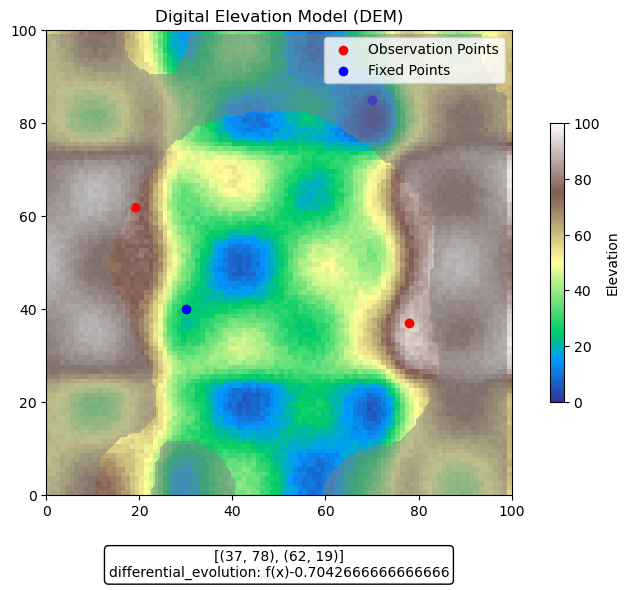

Polishing solution with 'L-BFGS-B'
[(37.06711880762996, 78.20721300356081), (62.5578963315969, 19.612760293228707)]


In [24]:
# Fixed points that we will optimize around
fixed_points = np.array([[40, 30], [85, 70]])    # locations of pre-existing points (crds in float or int)

n_points = 2          # Int: number of new observation points to place to increase coverage 
obs_height =10        # Float or Int: Height of transmitter/ sensor - in map units, for ALL towers (including pre existing)
obs_max_radius = 40   # Float or Int: Maximum transmission/view distance from tower
n_rays = 90           # Int: Number of rays cast to generate polygon - complex terrain at distance will require more rays, defaut 90 (4 degrees between rays)
method = '3d_poly'    # Two options: '3d_poly' (faster by about 8x), '3d_poly_with_obstructions' (more accurate, especially in complex terrain)

obs_pts = visibility_optimized_points_3d(dem=dem,
                                         valid_mask=valid_mask,
                                         n_points = n_points,
                                         method=method,
                                         obs_height=obs_height,
                                         max_radius=obs_max_radius,
                                         num_rays=n_rays,
                                         fixed_points=fixed_points,
                                        )
observation_points, fixed_points, observation_polygons, fixed_polygons = obs_pts
print(observation_points)




In [27]:
type(test)

NoneType

In [30]:
#observation_points
#fixed_points
#total_visible_area
observation_polygons
fixed_polygons

[<POLYGON ((46 30, 46 30, 48 31, 59 34, 59 36, 58 36, 58 38, 58 39, 59 42, 59...>,
 <POLYGON ((88 70, 88 70, 88 70, 88 71, 88 71, 88 71, 88 71, 88 71, 88 72, 88...>]

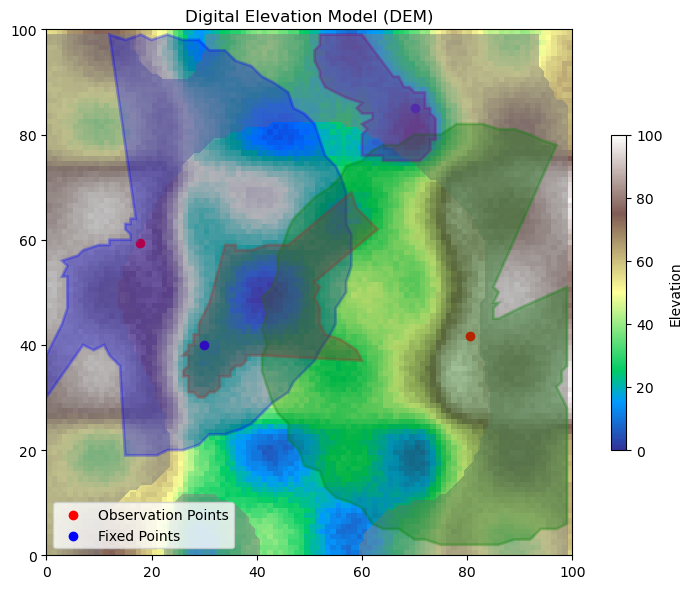

In [31]:
plot_observation_points_with_polygons_3d(dem=dem,
                                         valid_mask=valid_mask,
                                         observation_points=observation_points,
                                         fixed_points=fixed_points,
                                         observation_polygons=observation_polygons,
                                         fixed_polygons=fixed_polygons,
                                         obs_height=obs_height,
                                         max_radius=obs_max_radius,
                                         num_rays=n_rays
                                        )

In [32]:
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, HTML

In [23]:
# Function to create the 3D plot using Plotly

def plot_dem(dem, valid_mask, observation_points, fixed_points, observation_polygons, fixed_polygons, obs_height, elev=30, azim=45):
    x = np.arange(dem.shape[1])
    y = np.arange(dem.shape[0])
    x, y = np.meshgrid(x, y)
    z = dem

    # Create surface plot for DEM
    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y, colorscale='tropic', opacity=0.8)])

    # Overlay valid areas
    fig.add_trace(go.Surface(z=z, x=x, y=y, surfacecolor=valid_mask, opacity=0.3))

    # Plot observation points
    obs_x = [p[1] for p in observation_points]
    obs_y = [p[0] for p in observation_points]
    obs_z = [dem[int(p[0]), int(p[1])] + obs_height for p in observation_points]
    fig.add_trace(go.Scatter3d(x=obs_x, y=obs_y, z=obs_z, mode='markers', marker=dict(size=5, color='red'), name='Observation Points'))

    # Plot fixed points
    fixed_x = [p[1] for p in fixed_points]
    fixed_y = [p[0] for p in fixed_points]
    fixed_z = [dem[int(p[0]), int(p[1])] + obs_height for p in fixed_points]
    fig.add_trace(go.Scatter3d(x=fixed_x, y=fixed_y, z=fixed_z, mode='markers', marker=dict(size=5, color='blue'), name='Fixed Points'))

    # Add lines from observation points to terrain surface
    for p in observation_points:
        obs_x, obs_y = p[1], p[0]
        obs_z_surface = dem[int(p[0]), int(p[1])]
        obs_z_point = obs_z_surface + obs_height
        fig.add_trace(go.Scatter3d(x=[obs_x, obs_x], y=[obs_y, obs_y], z=[obs_z_point, obs_z_surface], mode='lines', line=dict(color='red', width=2), showlegend=False))

    # Add lines from fixed points to terrain surface
    for p in fixed_points:
        fixed_x, fixed_y = p[1], p[0]
        fixed_z_surface = dem[int(p[0]), int(p[1])]
        fixed_z_point = fixed_z_surface + obs_height
        fig.add_trace(go.Scatter3d(x=[fixed_x, fixed_x], y=[fixed_y, fixed_y], z=[fixed_z_point, fixed_z_surface], mode='lines', line=dict(color='blue', width=2), showlegend=False))

    # Add polygons at the respective height of each observation point
    for idx, polygon in enumerate(observation_polygons):
        polygon_points = np.array(polygon.exterior.coords)
        polygon_points = np.column_stack((polygon_points[:, 1], polygon_points[:, 0], np.full_like(polygon_points[:, 0], obs_z[idx])))
        fig.add_trace(go.Mesh3d(x=polygon_points[:, 0], y=polygon_points[:, 1], z=polygon_points[:, 2], opacity=0.15, color='salmon', name=f'Polygon {idx+1}'))

    # Add polygons at the respective height of each fixed point
    for idx, polygon in enumerate(fixed_polygons):
        polygon_points = np.array(polygon.exterior.coords)
        polygon_points = np.column_stack((polygon_points[:, 1], polygon_points[:, 0], np.full_like(polygon_points[:, 0], fixed_z[idx])))
        fig.add_trace(go.Mesh3d(x=polygon_points[:, 0], y=polygon_points[:, 1], z=polygon_points[:, 2], opacity=0.15, color='dodgerblue', name=f'Fixed Polygon {idx+1}'))

    # Set layout
    fig.update_layout(
        title='3D View of DEM, Valid Areas, & Observation Points',
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Elevation',
                   aspectmode='manual', aspectratio=dict(x=1, y=1, z=0.5),
                   camera=dict(eye=dict(x=np.sin(np.deg2rad(azim))*np.cos(np.deg2rad(elev)),
                                        y=np.sin(np.deg2rad(azim))*np.sin(np.deg2rad(elev)),
                                        z=np.cos(np.deg2rad(elev)))),
                   xaxis=dict(range=[0, dem.shape[1]]),
                   yaxis=dict(range=[0, dem.shape[0]]),
                   zaxis=dict(range=[dem.min(), max(dem.max(), max(obs_z))])
        ),
        width=1000,
        height=800
    )

    # Adjust colorbar position and size
    fig.update_layout(coloraxis_colorbar=dict(yanchor='top', y=0.9, len=0.4))

    # Show plot
    fig.show()





# Create interactive widgets
elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elevation')
azim_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=45, description='Azimuth')

# Inject CSS for cell height
display(HTML("""
<style>
.jp-OutputArea {
    max-height: 800px;
    overflow-y: auto;
}
</style>
"""))

# Display interactive plot
interact(plot_dem, dem=widgets.fixed(dem), valid_mask=widgets.fixed(valid_mask),
         observation_points=widgets.fixed(observation_points), observation_polygons=widgets.fixed(observation_polygons),
         fixed_points=widgets.fixed(fixed_points), fixed_polygons=widgets.fixed(fixed_polygons),
         obs_height=widgets.fixed(obs_height), elev=elev_slider, azim=azim_slider)



interactive(children=(FloatSlider(value=30.0, description='Elevation', max=90.0, step=1.0), FloatSlider(value=…

<function __main__.plot_dem(dem, valid_mask, observation_points, fixed_points, observation_polygons, fixed_polygons, obs_height, elev=30, azim=45)>

Do a quick example on a real DEM, we will use Yosemite 

In [24]:
import rasterio
import numpy as np

# Open the GeoTIFF file
file_path = './data/output_SRTMGL1.tif'  #Yosimite 30m DEM
#file_path = './data/output_USGS30m.tif'  #Santa Barbra 30m DEM
#file_path = './data/output_USGS30m_Austin_NV.tif'  #Austin, NV Basin and Range 30m DEM
with rasterio.open(file_path) as src:
    # Read the dataset's data as a numpy array
    dem = src.read()

# The array is now a NumPy array
print(dem)
print(dem.shape)

dem = dem[0,::-1,...] #take first slice of 3d array, invert y axis (image crds upper left y idx vs regular lower left), remaining axes (x axis) as is
print(dem.shape)


# create a valid everywhere array
valid_mask = np.where(dem > 0, 1, 0)
print(valid_mask.shape)

[[[2557 2561 2562 ... 2044 2037 2032]
  [2551 2552 2556 ... 2016 2014 2013]
  [2546 2543 2547 ... 1998 1997 1994]
  ...
  [2146 2143 2137 ... 2407 2402 2401]
  [2149 2141 2136 ... 2401 2399 2397]
  [2152 2145 2137 ... 2394 2394 2392]]]
(1, 345, 514)
(345, 514)
(345, 514)


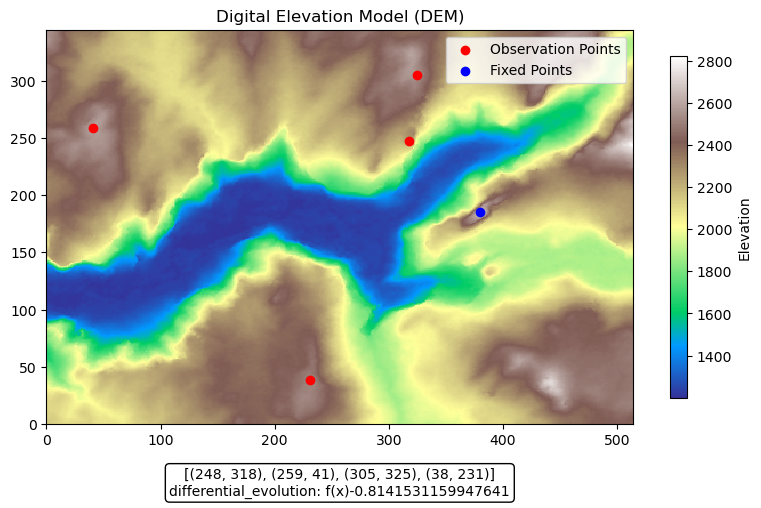

Polishing solution with 'L-BFGS-B'
[(248.91990177488248, 318.15126428429915), (259.8319263611042, 41.19349362952124), (305.39814812059745, 325.04378668973357), (38.99230084220423, 231.096743071953)]


In [25]:
# Fixed points that we will optimize around
fixed_points = np.array([[185, 380]])    # in form (Y, X)

n_points = 4
obs_height = 0.5      # in map units - so a obs_heright of 1 on a 30m dem would be 30 meters
obs_max_radius =200
n_rays = 90
method = '3d_poly' #_with_obstructions 

obs_pts = visibility_optimized_points_3d(dem=dem,
                                         valid_mask=valid_mask,
                                         n_points = n_points,
                                         method=method,
                                         obs_height=obs_height,
                                         max_radius=obs_max_radius,
                                         num_rays=n_rays,
                                         fixed_points=fixed_points,
                                        )
observation_points, fixed_points, observation_polygons, fixed_polygons = obs_pts
print(observation_points)



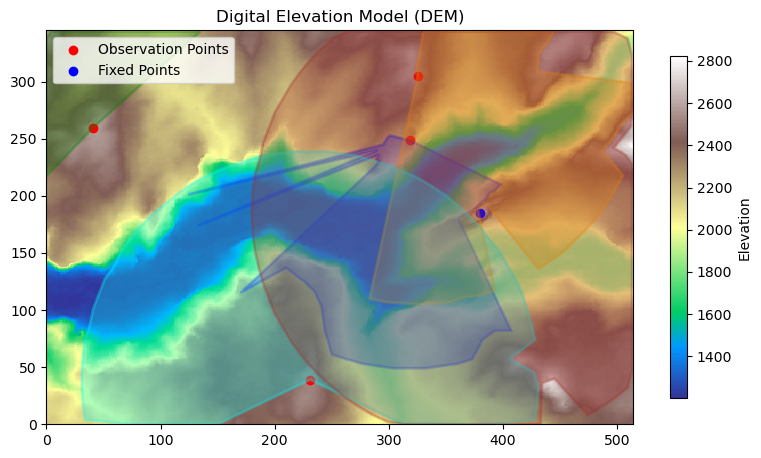

In [26]:
plot_observation_points_with_polygons_3d(dem=dem,
                                         valid_mask=valid_mask,
                                         observation_points=observation_points,
                                         fixed_points=fixed_points,
                                         observation_polygons=observation_polygons,
                                         fixed_polygons=fixed_polygons,
                                         obs_height=obs_height,
                                         max_radius=obs_max_radius,
                                         num_rays=n_rays)

In [27]:
# Display interactive plot
interact(plot_dem, dem=widgets.fixed(dem), valid_mask=widgets.fixed(valid_mask),
         observation_points=widgets.fixed(observation_points), observation_polygons=widgets.fixed(observation_polygons),
         fixed_points=widgets.fixed(fixed_points), fixed_polygons=widgets.fixed(fixed_polygons),
         obs_height=widgets.fixed(obs_height), elev=elev_slider, azim=azim_slider)

interactive(children=(FloatSlider(value=30.0, description='Elevation', max=90.0, step=1.0), FloatSlider(value=…

<function __main__.plot_dem(dem, valid_mask, observation_points, fixed_points, observation_polygons, fixed_polygons, obs_height, elev=30, azim=45)>